# Assignment 4
Daniel Fylling

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import matplotlib.animation as animation
import matplotlib
%matplotlib inline
import pandas as pd


In [63]:
# Define number of grid cells
nx = 50
ny = 50

# Create mesh grid for x and y
x = np.arange(1,nx+1,1).reshape(-1,1)
y = np.arange(1,ny+1,1).reshape(-1,1)
x_grid, y_grid = np.meshgrid(x, y)

# Flatten each mesh grid
x_grid_flat = x_grid.reshape(1, nx*ny)
y_grid_flat = y_grid.reshape(1, nx*ny)

# Find distance from each grid point to every other grid point
x_dist = x_grid_flat - x_grid_flat.T
y_dist = y_grid_flat - y_grid_flat.T
dist = np.sqrt(np.square(x_dist) + np.square(y_dist))
#plt.pcolormesh(dist)


In [64]:
# Define input data as per assignment
mean_phi = 4
ra = 1
gamma = 1
sigma = 1
n_real = 1

# Calculate covariance matrix from distance matrix
Cov_phi = np.square(sigma)*np.exp(-3*np.power(dist/ra, gamma))
#plt.pcolormesh(Cov_phi)

In [65]:
# Find square root of covaraince matrix / standard deviation
u, s, vh = np.linalg.svd(Cov_phi)
s = np.diag(s)
s_sqrt = np.sqrt(s)
Cov_phi_sqrt = np.linalg.multi_dot((u, s_sqrt, vh))

In [66]:
# Draw random numbers for each realization
z = ss.norm.rvs(loc=0, scale=1, size=(nx*ny, n_real))

In [67]:
# Calculate all realizations
phi_real_all = mean_phi + np.dot(Cov_phi_sqrt, z)

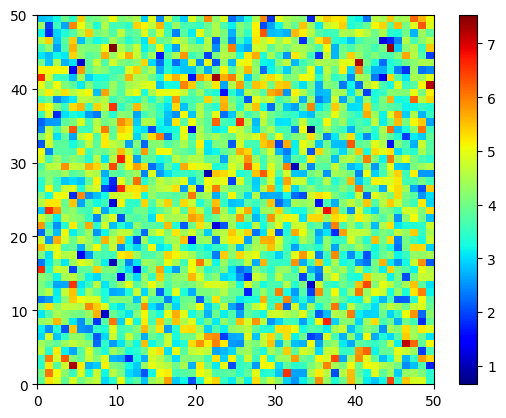

In [68]:
# Define function to fetch a given realization
def phi_real_i(i):
    return phi_real_all[:,i-1].reshape((nx, ny))

plt.pcolormesh(phi_real_i(1), cmap='jet')
plt.colorbar()

In [56]:
# Switching matplotlib viewer to enable animations
matplotlib.use('WebAgg')

# Create the initial plot
fig, ax = plt.subplots()
im = ax.pcolormesh(x_grid, y_grid, phi_real_i(1), cmap='viridis')

# Define the update function for the animation
def animate(i):
    im.set_array(phi_real_i(i).ravel())
    ax.set_title(f"Frame {i}")
    return im,

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames = np.arange(1,n_real+1), interval=200)
plt.show()

### Task 2

In [37]:
%matplotlib inline
df_data = pd.read_excel (r'stock_price_data.xlsx')
df_data

,Date,Relative Time (days),Relative Time (years),Price ($)
0,2019-10-28,0,0.000000,62.661999
1,2019-11-04,7,0.019178,67.428001
2,2019-11-11,14,0.038356,70.433998
3,2019-11-18,21,0.057534,66.608002
4,2019-11-25,28,0.076712,65.987999
...,...,...,...,...
100,2021-09-27,700,1.917808,775.219971
101,2021-10-04,707,1.936986,785.489990
102,2021-10-11,714,1.956164,843.030029
103,2021-10-18,721,1.975342,909.679993


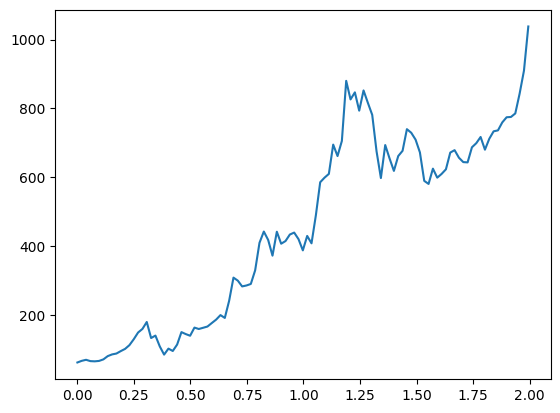

In [38]:
# Visalize data
plt.plot(df_data['Relative Time (years)'].values, df_data['Price ($)'].values)


In [39]:
dt = 7/365 # years

### a) GBM Calibration

#### Calculate $x_t=ln(S_{t+dt}/S_t)$

In [ ]:
# Calculate x_t according to formula
S_next = df_data['Price ($)'].values[1:]
S_pre = df_data['Price ($)'].values[0:-1]
x_t = np.log(S_next/S_pre)

In [41]:
# Calculate mean and standard devaition of x_t
x_mean = np.mean(x_t)
x_sd = np.std(x_t)

print(x_mean, x_sd)

0.026991932481463796 0.09876476949744876


In [42]:
# Calculate GBM parameters mu and sigma
mu_gbm = (2*x_mean+x_sd**2)/(2*dt)
sigma_gbm = x_sd/np.sqrt(dt)

print(mu_gbm, sigma_gbm)

1.661749699981164 0.7131805109375213


In [43]:
# Set S_0 to last value in time series
S_0 = df_data['Price ($)'].values[-1]

# Establish relative times for forecasting 3 weeks ahead
t_forecast = 7*np.arange(4)/365 # 

# Generate forecast
S_forecast = S_0*np.exp(mu_gbm*t_forecast)
S_forecast

array([1037.859985  , 1071.46841568, 1106.16516909, 1141.98548777])

In [ ]:
# Calculate P05 and P95 outcomes
lnS_t_mean_gbm = np.log(S_0)+(mu_gbm-sigma_gbm**2/2)*t_forecast
lnS_t_var_gbm = sigma_gbm**2*t_forecast
lnS_t_P05_gbm = ss.norm.ppf(q=0.05, loc=lnS_t_mean_gbm, scale=np.sqrt(lnS_t_var_gbm))
lnS_t_P05_gbm[0] = np.log(S_0)
lnS_t_P95_gbm = ss.norm.ppf(q=0.95, loc=lnS_t_mean_gbm, scale=np.sqrt(lnS_t_var_gbm))
lnS_t_P95_gbm[0] = np.log(S_0)
S_t_P05_gbm = np.exp(lnS_t_P05_gbm)
S_t_P95_gbm = np.exp(lnS_t_P95_gbm)

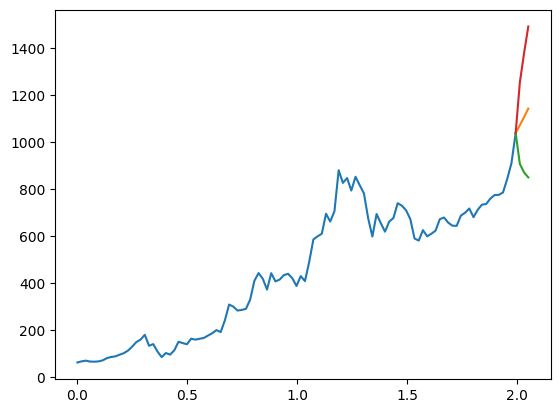

In [45]:
# Visalize forecast
plt.plot(df_data['Relative Time (years)'].values, df_data['Price ($)'].values)
plt.plot(t_forecast + df_data['Relative Time (days)'].values[-1]/365, S_forecast)
plt.plot(t_forecast + df_data['Relative Time (days)'].values[-1]/365, S_t_P05_gbm)
plt.plot(t_forecast + df_data['Relative Time (days)'].values[-1]/365, S_t_P95_gbm)

In [46]:
print(f'P05-P95 interval after 3 weeks is {S_t_P05_gbm[-1]:.1f} to {S_t_P95_gbm[-1]:.1f}')

P05-P95 interval after 3 weeks is 849.4 to 1491.1


### b) GOU Calibration

#### Calculate $\pi_t=ln(S_t)$

In [47]:
pi_t = np.log(df_data['Price ($)'].values)

#### Let $x_t=\pi_t$ and $y_t=\pi_{t+dt}$

In [48]:
x_t = pi_t[:-1]
y_t = pi_t[1:]


In [49]:
regression = ss.linregress(x = x_t, y = y_t)
a = regression.slope
b = regression.intercept
print(a,b)

0.9817982221362007 0.13284985994263465


#### Calculate regression residuals and the SD of the residuals 

In [50]:
y_reg = a*x_t + b
residuals = y_t - y_reg
residuals_sd = np.std(residuals, ddof=1)
residuals_sd

0.09806476191560043

#### Calculate GOU parameters: $\mu$, $\theta$, and $\sigma$

In [51]:
mu_gou = b/(1-a)
theta_gou = -np.log(a)/dt
sigma_gou = residuals_sd*np.sqrt(-2*np.log(a)/(dt*(1-a**2)))
print(mu_gou, theta_gou, sigma_gou)

7.29872987884628 0.9578365551292606 0.7146395667743817


### GOU Forecasting 

In [52]:
# Calculate forecasted mean

S_0 = df_data['Price ($)'].values[-1]
lnS_0 = np.log(S_0)

lnS_t_mean_gou = lnS_0*np.exp(-theta_gou*t_forecast)+mu_gou*(1-np.exp(-theta_gou*t_forecast))
lnS_t_var_gou = sigma_gou**2/(2*theta_gou)*(1-np.exp(-2*theta_gou*t_forecast))
S_t_mean_gou = np.exp(lnS_t_mean_gou+lnS_t_var_gou/2)
S_t_mean_gou

array([1037.859985  , 1049.60014129, 1061.16460936, 1072.55369358])

In [53]:
# Calculate forecasted P05 and P95

lnS_t_P05_gou = ss.norm.ppf(q=0.05, loc = lnS_t_mean_gou, scale = np.sqrt(lnS_t_var_gou))
lnS_t_P05_gou[0] = np.log(S_0)

lnS_t_P95_gou = ss.norm.ppf(q=0.95, loc = lnS_t_mean_gou, scale = np.sqrt(lnS_t_var_gou))
lnS_t_P95_gou[0] = np.log(S_0)

S_t_P05_gou = np.exp(lnS_t_P05_gou)
S_t_P95_gou = np.exp(lnS_t_P95_gou)

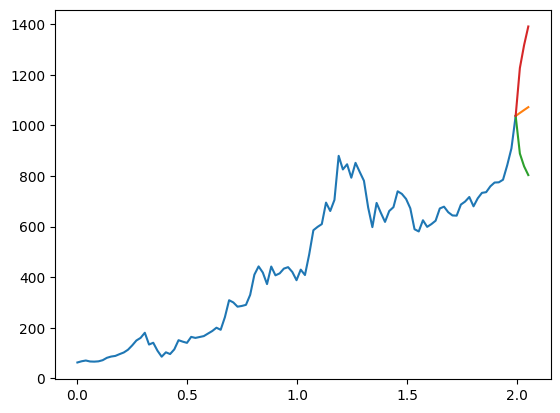

In [54]:
# Visalize GOU forecast
plt.plot(df_data['Relative Time (years)'].values, df_data['Price ($)'].values)
plt.plot(t_forecast + df_data['Relative Time (days)'].values[-1]/365, S_t_mean_gou)
plt.plot(t_forecast + df_data['Relative Time (days)'].values[-1]/365, S_t_P05_gou)
plt.plot(t_forecast + df_data['Relative Time (days)'].values[-1]/365, S_t_P95_gou)

In [55]:
print(f'P05-P95 interval after 3 weeks is {S_t_P05_gou[-1]:.1f} to {S_t_P95_gou[-1]:.1f}')

P05-P95 interval after 3 weeks is 803.9 to 1391.7


### c) GBM vs GOU

We can see that the forecasts from the two different models are quite similar in this case and it would be tough to say which one predicts the uncertainty of the future stock price better. 

In general I would not recommend using any of these models for predicting future stock prices. Stocks are influenced by other factors than its own history, such as human psychology. Mathematical models do not include such complex influences, which are critical to modern macroeconomic movements.